## PINN code for Nordgren Frac Model

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
# Define constants
E_prime = 10.0      # Example value for E'
mu = 1.0           # Example value for viscosity mu
H = 1.0            # Example value for height H
C_L = 1.0          # Example value for C_L
t_0 = 0.0          # Example initial time

In [3]:
# Define the input layers for x and t, then concatenate
input_x = tf.keras.layers.Input(shape=(1,), name="x")
input_t = tf.keras.layers.Input(shape=(1,), name="t")
inputs = tf.keras.layers.Concatenate()([input_x, input_t])

In [4]:
# Define the hidden layers
x = tf.keras.layers.Dense(20, activation="tanh")(inputs)
x = tf.keras.layers.Dense(20, activation="tanh")(x)
x = tf.keras.layers.Dense(20, activation="tanh")(x)
x = tf.keras.layers.Dense(20, activation="tanh")(x)

In [5]:
# Output layer
output = tf.keras.layers.Dense(1, activation=None)(x)

In [6]:
# Build the model
model = tf.keras.Model(inputs=[input_x, input_t], outputs=output)

In [7]:
# Define the loss function
def loss_function(x, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        w0 = model([x, t])

        # Compute gradients
        w0_t = tape.gradient(w0, t)
        w0_x = tape.gradient(w0, x)
        w0_xx = tape.gradient(w0_x, x)

    # Define the differential equation residual
    residual = (E_prime / (128 * mu * H)) * w0_xx - (8 * C_L / (np.pi * tf.sqrt(t - t_0))) - w0_t

    # Compute mean squared error for the residual
    loss = tf.reduce_mean(tf.square(residual))
    return loss

In [8]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Training step
def train_step(x, t):
    with tf.GradientTape() as tape:
        loss = loss_function(x, t)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [9]:

# Generate collocation points (x, t)
num_points = 1000
x_collocation = tf.random.uniform((num_points, 1), minval=0.0, maxval=1.0)
t_collocation = tf.random.uniform((num_points, 1), minval=0.0, maxval=1.0)

In [10]:
# Training loop
epochs = 1000
for epoch in range(epochs):
    loss = train_step(x_collocation, t_collocation)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Now the model is trained, and we can use it to predict w0(x, t) for given (x, t)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 0, Loss: 54.90000915527344
Epoch 100, Loss: 9.427041053771973
Epoch 200, Loss: 4.077280521392822
Epoch 300, Loss: 2.0078201293945312
Epoch 400, Loss: 1.0970041751861572
Epoch 500, Loss: 0.6777179837226868
Epoch 600, Loss: 0.4454554617404938
Epoch 700, Loss: 0.29647135734558105
Epoch 800, Loss: 0.20056389272212982
Epoch 900, Loss: 0.14418582618236542


## Plot

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


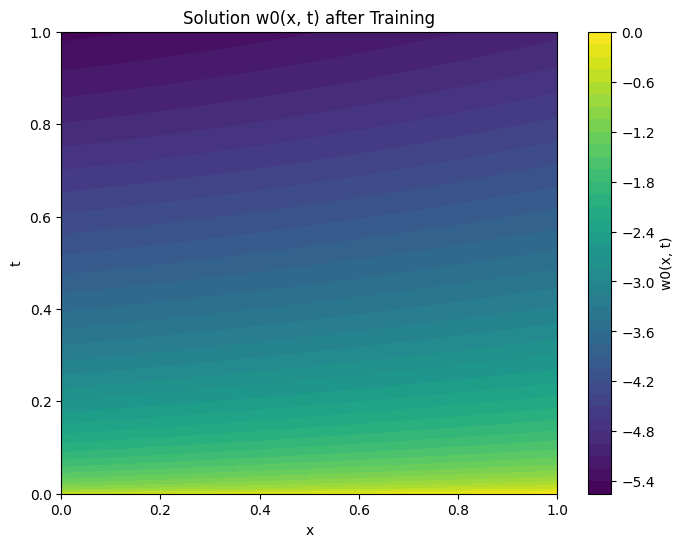

Epoch 0, Loss: 0.10525506734848022
Epoch 1, Loss: 0.10507386177778244
Epoch 2, Loss: 0.10504473000764847
Epoch 3, Loss: 0.10502126067876816
Epoch 4, Loss: 0.10497134178876877
Epoch 5, Loss: 0.10472898930311203
Epoch 6, Loss: 0.10443440824747086
Epoch 7, Loss: 0.10397292673587799
Epoch 8, Loss: 0.10351745784282684
Epoch 9, Loss: 0.10303199291229248
Epoch 10, Loss: 0.10260403156280518
Epoch 11, Loss: 0.1022321805357933
Epoch 12, Loss: 0.10192296653985977
Epoch 13, Loss: 0.10166695713996887
Epoch 14, Loss: 0.10144667327404022
Epoch 15, Loss: 0.10124852508306503
Epoch 16, Loss: 0.10105383396148682
Epoch 17, Loss: 0.10086920857429504
Epoch 18, Loss: 0.10066487640142441
Epoch 19, Loss: 0.10047394037246704
Epoch 20, Loss: 0.10025395452976227
Epoch 21, Loss: 0.10006245970726013
Epoch 22, Loss: 0.09983964264392853
Epoch 23, Loss: 0.09966520220041275
Epoch 24, Loss: 0.09945791214704514
Epoch 25, Loss: 0.09932578355073929
Epoch 26, Loss: 0.09915532171726227
Epoch 27, Loss: 0.09910671412944794
Epo

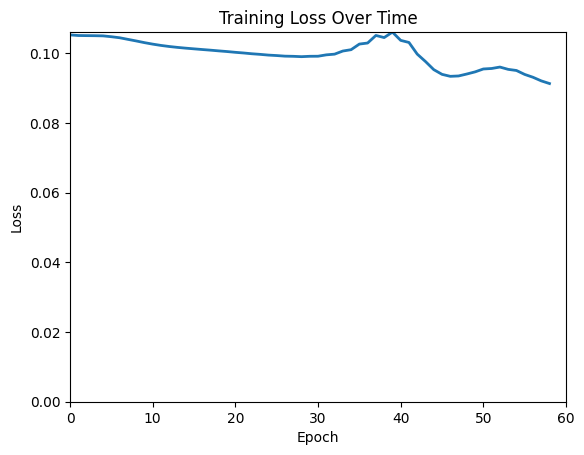

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Assuming the trained model model exists and other parameters are defined.

# 1. Static Plot of Solution
# Define the range and grid for plotting
x_vals = np.linspace(0, 1, 100)  # Range of x values
t_vals = np.linspace(0, 1, 100)  # Range of t values
X, T = np.meshgrid(x_vals, t_vals)
x_flat = X.flatten()[:, None]
t_flat = T.flatten()[:, None]

# Predict solution w0(x, t) over the grid
w0_pred = model.predict([x_flat, t_flat])
W0 = w0_pred.reshape(X.shape)

# Plotting the solution w0(x, t)
plt.figure(figsize=(8, 6))
plt.contourf(X, T, W0, levels=50, cmap="viridis")
plt.colorbar(label="w0(x, t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Solution w0(x, t) after Training")
plt.show()

# 2. Training Animation of Loss
# Store losses for each epoch to animate
loss_history = []

# Update the train_step function to store the loss
def train_step(x, t):
    with tf.GradientTape() as tape:
        loss = loss_function(x, t)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    loss_history.append(loss.numpy())  # Store loss for animation
    return loss

# Re-run the training loop to capture losses
epochs = 60  # Adjust epochs as needed for animation
for epoch in range(epochs):
    loss = train_step(x_collocation, t_collocation)
    if epoch % 1 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Create the animation of loss over time
fig, ax = plt.subplots()
ax.set_xlim(0, epochs)
ax.set_ylim(0, max(loss_history))
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training Loss Over Time")

line, = ax.plot([], [], lw=2)

# Initialize function for FuncAnimation
def init():
    line.set_data([], [])
    return line,

# Update function for each frame
def update(frame):
    line.set_data(range(frame), loss_history[:frame])
    return line,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(loss_history), init_func=init, blit=True)

# Save as GIF
ani.save("training_loss.gif", writer=PillowWriter(fps=30))

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


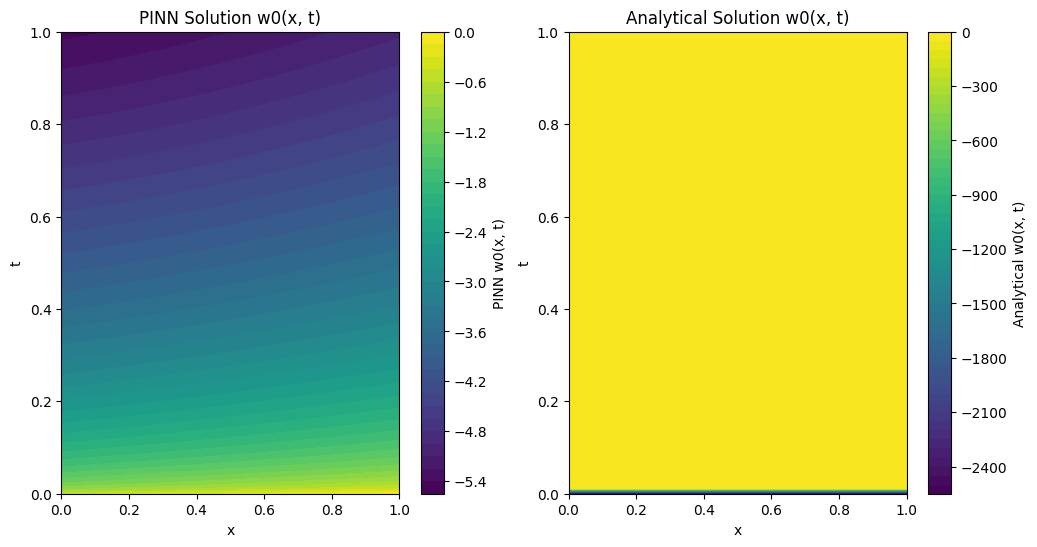

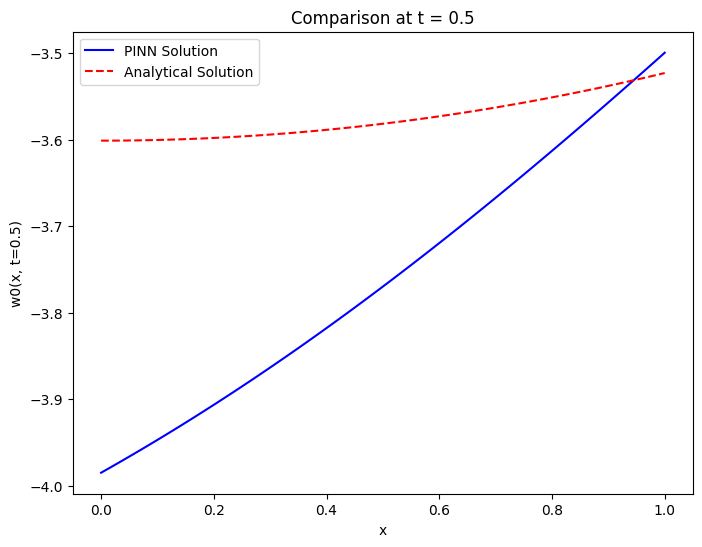

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range and grid for plotting
x_vals = np.linspace(0, 1, 100)  # Range of x values
t_vals = np.linspace(0, 1, 100)  # Range of t values
X, T = np.meshgrid(x_vals, t_vals)
x_flat = X.flatten()[:, None]
t_flat = T.flatten()[:, None]

# Predict the solution from the PINN model
w0_pinn_pred = model.predict([x_flat, t_flat])
W0_PINN = w0_pinn_pred.reshape(X.shape)

# Define the analytical solution (if available)
# Replace with the actual function if known
def analytical_solution(x, t):
    # Placeholder function - replace with the actual analytical solution of w0(x, t)
    return (E_prime / (128 * mu * H)) * (x ** 2) - (8 * C_L / (np.pi * np.sqrt(t - t_0 + 1e-6)))

# Calculate the analytical solution over the grid
W0_analytical = analytical_solution(X, T)

# Plot the PINN solution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.contourf(X, T, W0_PINN, levels=50, cmap="viridis")
plt.colorbar(label="PINN w0(x, t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("PINN Solution w0(x, t)")

# Plot the analytical solution
plt.subplot(1, 2, 2)
plt.contourf(X, T, W0_analytical, levels=50, cmap="viridis")
plt.colorbar(label="Analytical w0(x, t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Analytical Solution w0(x, t)")

# Overlay both solutions for a 1D slice (e.g., t=0.5)
plt.figure(figsize=(8, 6))
slice_t = 0.5
t_slice = np.full_like(x_vals, slice_t)
w0_pinn_slice = model.predict([x_vals[:, None], t_slice[:, None]])
w0_analytical_slice = analytical_solution(x_vals, slice_t)

plt.plot(x_vals, w0_pinn_slice, label="PINN Solution", color="blue")
plt.plot(x_vals, w0_analytical_slice, label="Analytical Solution", color="red", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("w0(x, t=0.5)")
plt.title(f"Comparison at t = {slice_t}")
plt.legend()
plt.show()